In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import random
from dataclasses import dataclass
from enum import IntEnum
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "figure.figsize": (10, 6),
    "figure.dpi": 100,
})

In [2]:
class CurriculumLevel(IntEnum):
    BASIC = 1
    TEXTURE = 2
    OBJECT = 3
    ADVERSARIAL = 4


@dataclass(frozen=True)
class LevelSpec:
    name: str
    num_samples: int
    complexity_min: float
    complexity_max: float
    description: str


LEVEL_SPECS = {
    CurriculumLevel.BASIC: LevelSpec(
        name="Basic Shapes",
        num_samples=5000,
        complexity_min=0.0,
        complexity_max=0.25,
        description="Simple geometric shapes with solid colors",
    ),
    CurriculumLevel.TEXTURE: LevelSpec(
        name="Textures",
        num_samples=10000,
        complexity_min=0.25,
        complexity_max=0.50,
        description="Texture patterns without semantic objects",
    ),
    CurriculumLevel.OBJECT: LevelSpec(
        name="Complex Objects",
        num_samples=20000,
        complexity_min=0.50,
        complexity_max=0.75,
        description="Multiple objects with background variation",
    ),
    CurriculumLevel.ADVERSARIAL: LevelSpec(
        name="Adversarial",
        num_samples=10000,
        complexity_min=0.75,
        complexity_max=1.0,
        description="Visually similar but semantically different",
    ),
}

In [3]:
class SyntheticGenerator:

    def __init__(self, image_size: int = 84, seed: Optional[int] = None):
        self._image_size = image_size
        self._generator = torch.Generator()
        if seed is not None:
            self._generator.manual_seed(seed)

    def generate_basic_shape(self) -> torch.Tensor:
        image = torch.zeros(3, self._image_size, self._image_size)
        color = torch.rand(3, generator=self._generator)
        center_y = self._image_size // 2
        center_x = self._image_size // 2
        radius = torch.randint(
            self._image_size // 8,
            self._image_size // 3,
            (1,),
            generator=self._generator,
        ).item()
        y_coords = torch.arange(self._image_size).view(-1, 1)
        x_coords = torch.arange(self._image_size).view(1, -1)
        shape_type = torch.randint(0, 3, (1,), generator=self._generator).item()
        if shape_type == 0:
            dist_sq = (y_coords - center_y) ** 2 + (x_coords - center_x) ** 2
            mask = dist_sq <= radius ** 2
        elif shape_type == 1:
            mask = (
                (torch.abs(y_coords - center_y) <= radius) &
                (torch.abs(x_coords - center_x) <= radius)
            )
        else:
            manhattan = (
                torch.abs(y_coords - center_y) +
                torch.abs(x_coords - center_x)
            )
            mask = manhattan <= radius
        for c in range(3):
            image[c][mask] = color[c]
        return image

    def generate_texture(self) -> torch.Tensor:
        image = torch.zeros(3, self._image_size, self._image_size)
        base_freq = torch.rand(1, generator=self._generator).item() * 10 + 5
        y_coords = torch.arange(self._image_size, dtype=torch.float32).view(-1, 1)
        x_coords = torch.arange(self._image_size, dtype=torch.float32).view(1, -1)
        for c in range(3):
            phase = torch.rand(1, generator=self._generator).item() * 6.28
            freq_var = torch.rand(1, generator=self._generator).item() * 2
            frequency = base_freq + freq_var
            normalized = (y_coords + x_coords) / self._image_size
            pattern = torch.sin(normalized * frequency * 6.28 + phase)
            noise = torch.rand(
                self._image_size,
                self._image_size,
                generator=self._generator,
            ) * 0.2
            image[c] = (pattern + 1) / 2 + noise
        return torch.clamp(image, 0, 1)

    def generate_complex_object(self) -> torch.Tensor:
        bg_color = torch.rand(3, generator=self._generator) * 0.3
        image = bg_color.view(3, 1, 1).expand(
            3, self._image_size, self._image_size
        ).clone()
        num_shapes = torch.randint(2, 5, (1,), generator=self._generator).item()
        for _ in range(num_shapes):
            shape = self.generate_basic_shape()
            offset_y = torch.randint(-20, 21, (1,), generator=self._generator).item()
            offset_x = torch.randint(-20, 21, (1,), generator=self._generator).item()
            if offset_y != 0 or offset_x != 0:
                shape = torch.roll(shape, shifts=(offset_y, offset_x), dims=(1, 2))
            mask = shape.sum(dim=0) > 0
            image[:, mask] = shape[:, mask]
        return torch.clamp(image, 0, 1)

    def generate_adversarial(self) -> torch.Tensor:
        base = self.generate_complex_object()
        perturbation = torch.randn(
            3, self._image_size, self._image_size,
            generator=self._generator,
        ) * 0.1
        return torch.clamp(base + perturbation, 0, 1)

    def generate_for_level(self, level: CurriculumLevel) -> torch.Tensor:
        if level == CurriculumLevel.BASIC:
            return self.generate_basic_shape()
        elif level == CurriculumLevel.TEXTURE:
            return self.generate_texture()
        elif level == CurriculumLevel.OBJECT:
            return self.generate_complex_object()
        else:
            return self.generate_adversarial()

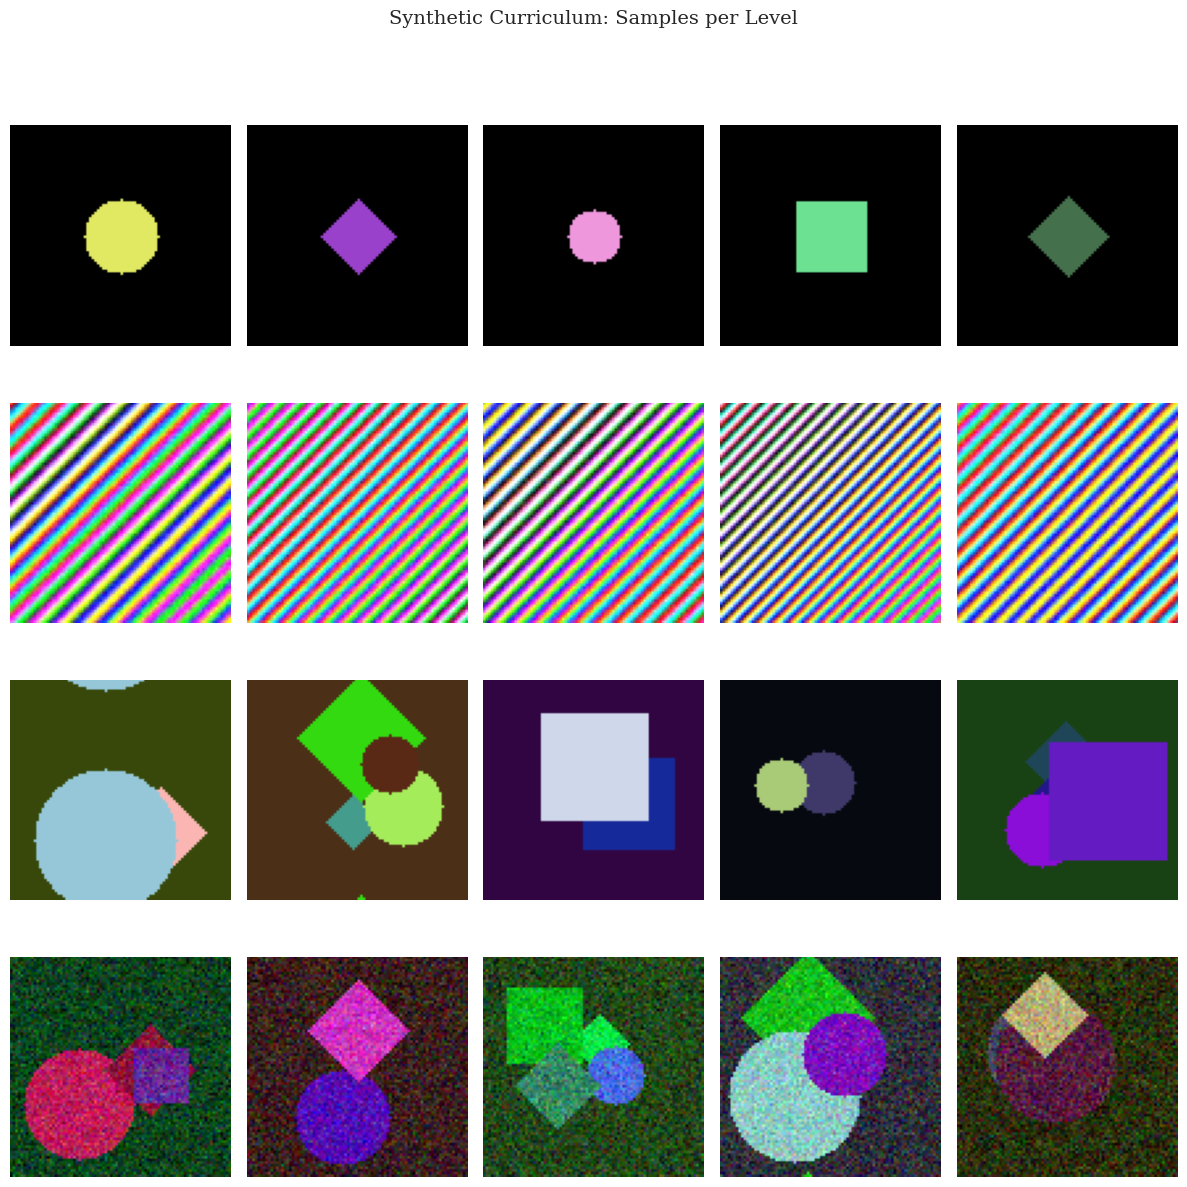

In [4]:
def visualize_curriculum_samples(
    generator: SyntheticGenerator,
    samples_per_level: int = 4
) -> plt.Figure:
    fig, axes = plt.subplots(4, samples_per_level, figsize=(12, 12))
    for level_idx, level in enumerate(CurriculumLevel):
        spec = LEVEL_SPECS[level]
        for sample_idx in range(samples_per_level):
            ax = axes[level_idx, sample_idx]
            image = generator.generate_for_level(level)
            image_np = image.permute(1, 2, 0).numpy()
            ax.imshow(image_np)
            ax.axis("off")
            if sample_idx == 0:
                ax.set_ylabel(spec.name, fontsize=10, rotation=90, labelpad=10)
    fig.suptitle("Synthetic Curriculum: Samples per Level", fontsize=14, y=1.02)
    plt.tight_layout()
    return fig


generator = SyntheticGenerator(image_size=84, seed=42)
fig = visualize_curriculum_samples(generator, samples_per_level=5)
plt.show()

In [5]:
class DifficultyScorer:

    def compute_edge_density(self, image: torch.Tensor) -> float:
        if image.dim() == 3:
            image = image.unsqueeze(0)
        grayscale = image.mean(dim=1, keepdim=True)
        sobel_x = torch.tensor(
            [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32
        ).view(1, 1, 3, 3)
        sobel_y = torch.tensor(
            [[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32
        ).view(1, 1, 3, 3)
        edges_x = F.conv2d(grayscale, sobel_x, padding=1)
        edges_y = F.conv2d(grayscale, sobel_y, padding=1)
        magnitude = torch.sqrt(edges_x ** 2 + edges_y ** 2)
        return magnitude.mean().item()

    def compute_color_variance(self, image: torch.Tensor) -> float:
        if image.dim() == 3:
            image = image.unsqueeze(0)
        return image.var(dim=(2, 3)).mean().item()

    def compute_spatial_frequency(self, image: torch.Tensor) -> float:
        if image.dim() == 3:
            image = image.unsqueeze(0)
        grayscale = image.mean(dim=1)
        fft_result = torch.fft.fft2(grayscale)
        magnitude = torch.abs(fft_result)
        return magnitude.mean().item()

    def compute_score(
        self,
        image: torch.Tensor,
        weights: tuple = (0.4, 0.3, 0.3)
    ) -> float:
        edge = min(self.compute_edge_density(image) / 10.0, 1.0)
        color = min(self.compute_color_variance(image) / 1.0, 1.0)
        freq = min(self.compute_spatial_frequency(image) / 50.0, 1.0)
        return weights[0] * edge + weights[1] * color + weights[2] * freq


def analyze_difficulty_distribution(
    generator: SyntheticGenerator,
    scorer: DifficultyScorer,
    samples_per_level: int = 100
) -> dict:
    scores_per_level = {}
    for level in CurriculumLevel:
        scores = []
        for _ in range(samples_per_level):
            image = generator.generate_for_level(level)
            score = scorer.compute_score(image)
            scores.append(score)
        scores_per_level[level] = scores
    return scores_per_level


scorer = DifficultyScorer()
difficulty_scores = analyze_difficulty_distribution(generator, scorer, samples_per_level=200)

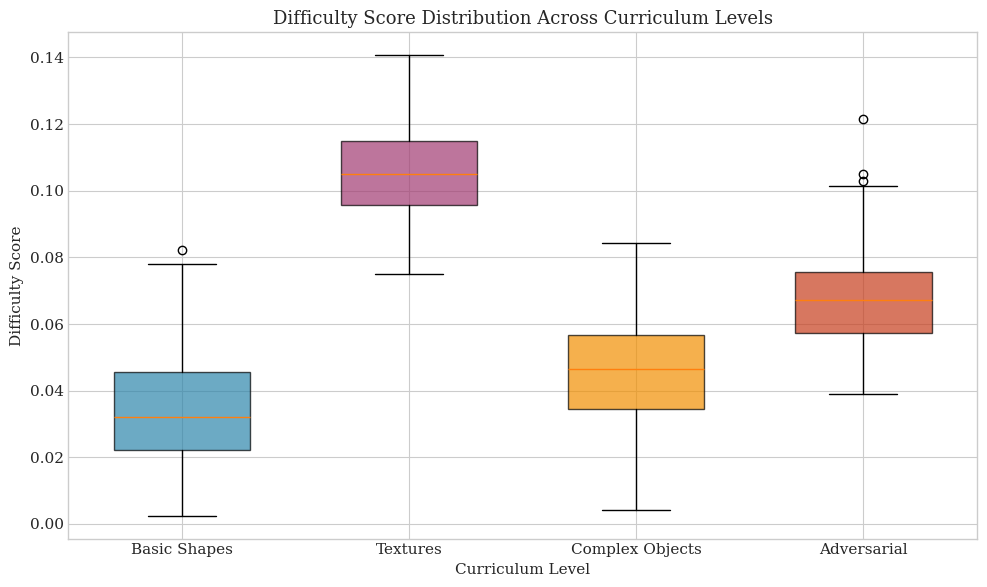

In [6]:
def plot_difficulty_distribution(scores_per_level: dict) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D"]
    positions = []
    for idx, (level, scores) in enumerate(scores_per_level.items()):
        spec = LEVEL_SPECS[level]
        pos = idx + 1
        positions.append(pos)
        bp = ax.boxplot(
            scores,
            positions=[pos],
            widths=0.6,
            patch_artist=True,
        )
        bp["boxes"][0].set_facecolor(colors[idx])
        bp["boxes"][0].set_alpha(0.7)
    ax.set_xticks(positions)
    ax.set_xticklabels([LEVEL_SPECS[l].name for l in CurriculumLevel])
    ax.set_xlabel("Curriculum Level")
    ax.set_ylabel("Difficulty Score")
    ax.set_title("Difficulty Score Distribution Across Curriculum Levels")
    plt.tight_layout()
    return fig


fig = plot_difficulty_distribution(difficulty_scores)
plt.show()

In [7]:
def print_dataset_statistics(scores_per_level: dict) -> None:
    print("=" * 70)
    print("CURRICULUM DATASET STATISTICS")
    print("=" * 70)
    print(f"{'Level':<20} {'Samples':>10} {'Mean':>10} {'Std':>10} {'Range':>15}")
    print("-" * 70)
    total_samples = 0
    for level in CurriculumLevel:
        spec = LEVEL_SPECS[level]
        scores = scores_per_level[level]
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        print(
            f"{spec.name:<20} {spec.num_samples:>10,} "
            f"{mean_score:>10.3f} {std_score:>10.3f} "
            f"[{min_score:.2f}, {max_score:.2f}]"
        )
        total_samples += spec.num_samples
    print("-" * 70)
    print(f"{'TOTAL':<20} {total_samples:>10,}")
    print("=" * 70)


print_dataset_statistics(difficulty_scores)

CURRICULUM DATASET STATISTICS
Level                   Samples       Mean        Std           Range
----------------------------------------------------------------------
Basic Shapes              5,000      0.034      0.016 [0.00, 0.08]
Textures                 10,000      0.106      0.014 [0.08, 0.14]
Complex Objects          20,000      0.046      0.015 [0.00, 0.08]
Adversarial              10,000      0.068      0.014 [0.04, 0.12]
----------------------------------------------------------------------
TOTAL                    45,000


In [8]:
BENCHMARK_DATASETS = {
    "MiniImageNet": {
        "total_classes": 100,
        "train_classes": 64,
        "val_classes": 16,
        "test_classes": 20,
        "samples_per_class": 600,
        "image_size": 84,
        "source": "ImageNet ILSVRC-2012 subset",
    },
    "CIFAR-FS": {
        "total_classes": 100,
        "train_classes": 64,
        "val_classes": 16,
        "test_classes": 20,
        "samples_per_class": 600,
        "image_size": 32,
        "source": "CIFAR-100 reorganized",
    },
}


def print_benchmark_info() -> None:
    print("\n" + "=" * 70)
    print("BENCHMARK DATASETS FOR FEW-SHOT EVALUATION")
    print("=" * 70)
    for name, info in BENCHMARK_DATASETS.items():
        print(f"\n{name}:")
        print("-" * 40)
        for key, value in info.items():
            print(f"  {key.replace('_', ' ').title()}: {value}")


print_benchmark_info()


BENCHMARK DATASETS FOR FEW-SHOT EVALUATION

MiniImageNet:
----------------------------------------
  Total Classes: 100
  Train Classes: 64
  Val Classes: 16
  Test Classes: 20
  Samples Per Class: 600
  Image Size: 84
  Source: ImageNet ILSVRC-2012 subset

CIFAR-FS:
----------------------------------------
  Total Classes: 100
  Train Classes: 64
  Val Classes: 16
  Test Classes: 20
  Samples Per Class: 600
  Image Size: 32
  Source: CIFAR-100 reorganized
